<a href="https://colab.research.google.com/github/deepskandpal/hands-on-machine-learning/blob/POC/Newyork_taxi_ETA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install geopandas

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import geopandas as gpd
from shapely.geometry import Point

     |████████████████████████████████| 972kB 2.9MB/s 
     |████████████████████████████████| 14.8MB 296kB/s 
     |████████████████████████████████| 10.9MB 39.0MB/s 


In [2]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"atdeepanshu","key":"efb7cfbda38df5a60eec6e85835e4859"}'}

In [3]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


In [4]:
!kaggle competitions download -c nyc-taxi-trip-duration


 91% 57.0M/62.9M [00:00<00:00, 89.2MB/s]
100% 62.9M/62.9M [00:00<00:00, 107MB/s] 
  0% 0.00/2.49M [00:00<?, ?B/s]
100% 2.49M/2.49M [00:00<00:00, 169MB/s]
 44% 9.00M/20.3M [00:00<00:00, 50.6MB/s]
100% 20.3M/20.3M [00:00<00:00, 80.4MB/s]


In [5]:
!ls

kaggle.json  sample_data  sample_submission.zip  test.zip  train.zip


In [6]:
train_data = pd.read_csv("train.zip")
train_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


## Explorately Data Analysis

In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [8]:
train_data.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


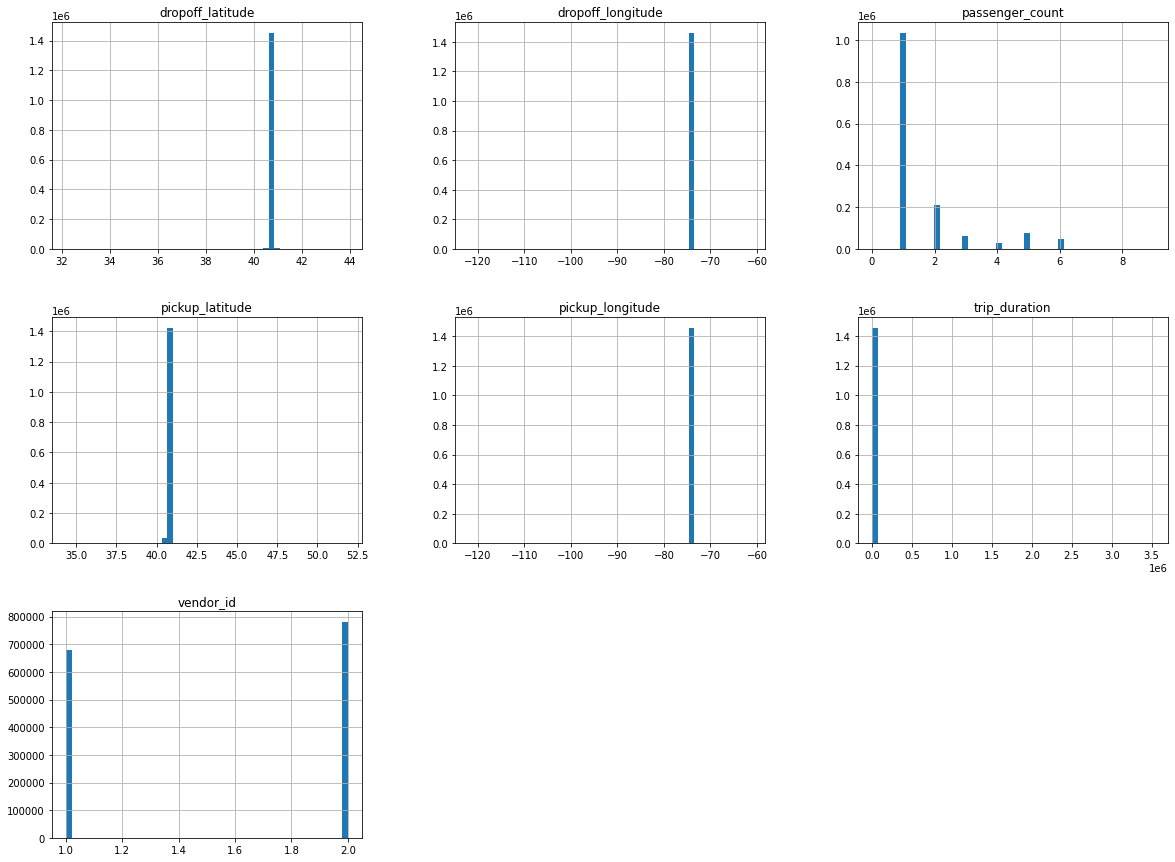

In [9]:
train_data.hist(bins=50, figsize=(20,15))
plt.show()

In [10]:
from geopy.geocoders import Nominatim
from geopy.distance import geodesic
geolocator = Nominatim(user_agent="my_app")
location = geolocator.reverse("40.767937, -73.982155")
location1 = (40.767937, -73.982155)
location2 = (40.765602, -73.964630)
addr1 = geolocator.reverse("40.767937, -73.982155")
addr2 = geolocator.reverse("40.765602, -73.964630")
print("addr1 =", addr1.address)
print("addr2 = ", addr2.address)
print(geodesic(location1, location2).m) 



addr1 = 59th Street–Columbus Circle, Columbus Circle, Manhattan Community Board 7, Manhattan, New York County, New York, 10023, United States of America
addr2 =  146, East 65th Street, Lenox Hill, Manhattan Community Board 8, Manhattan, New York County, New York, 10065, United States of America
1502.2029520818444


In [11]:
def get_distance_in_metre(df):
  start_point = (df["pickup_latitude"], df["pickup_longitude"])
  drop_point = (df["dropoff_latitude"], df["dropoff_longitude"])
  total_distance = geodesic(start_point, drop_point).m
  return total_distance

In [12]:
train_data['distance'] = train_data.apply(get_distance_in_metre, axis = 1) 

In [13]:
train_data_cpy = train_data.drop(["dropoff_longitude", "dropoff_latitude", "pickup_latitude", "pickup_longitude"], axis=1)

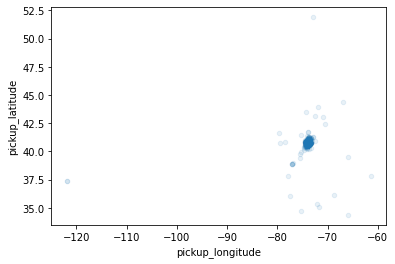

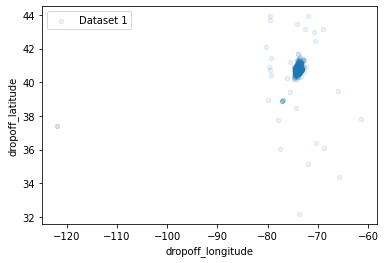

In [14]:
train_data.plot(kind="scatter", x="pickup_longitude", y="pickup_latitude", alpha=0.1)
train_data.plot(kind="scatter", x="dropoff_longitude", y="dropoff_latitude", alpha=0.1)

plt.legend(["Dataset 1", "Dataset 2"])

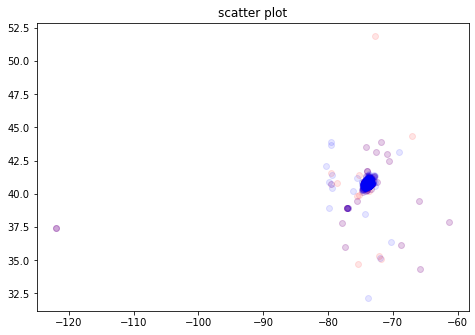

In [15]:
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(train_data["pickup_longitude"], train_data["pickup_latitude"], color='r', alpha=0.1)
ax.scatter(train_data["dropoff_longitude"], train_data["dropoff_latitude"], color='b', alpha=0.1)
ax.set_title('scatter plot')
plt.show()

In [16]:
geometry = [Point(xy for xy in zip(train_data["pickup_longitude"], train_data["pickup_latitude"]))]

In [17]:
corr_matrix = train_data.corr()
corr_matrix["trip_duration"].sort_values(ascending=False)


trip_duration        1.000000
distance             0.094789
pickup_longitude     0.026542
vendor_id            0.020304
dropoff_longitude    0.014678
passenger_count      0.008471
dropoff_latitude    -0.020677
pickup_latitude     -0.029204
Name: trip_duration, dtype: float64

In [18]:
train_data_cpy = train_data_cpy.round({"trip_duration":2, "distance":2}) 

train_data_cpy.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,store_and_fwd_flag,trip_duration,distance
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,N,455,1502.17
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,N,663,1808.66
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,N,2124,6379.69
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,N,429,1483.63
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,N,435,1187.04


In [19]:
from scipy import stats
print(train_data_cpy.distance.max()) 
print(train_data_cpy.trip_duration.max()) 
print(stats.trim_mean(train_data_cpy.trip_duration, 0.1))
print(stats.trim_mean(train_data_cpy.distance, 0.1))
#print(train_data_cpy.mean(axis = 0))
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
trip_duration = train_data_cpy.trip_duration.values.reshape(-1, 1)
distance = train_data_cpy.distance.values.reshape(-1,1)
train_data_cpy_trip_duration_scaled = min_max_scaler.fit_transform(trip_duration)
train_data_cpy_distance_scaled = min_max_scaler.fit_transform(distance)
print(train_data_cpy_trip_duration_scaled)

1240510.26
3526282
734.4517900174477
2578.768343076966
[[1.28747539e-04]
 [1.87733195e-04]
 [6.02050716e-04]
 ...
 [2.16375269e-04]
 [1.05493578e-04]
 [5.58662228e-05]]


In [20]:
train_data[train_data.trip_duration == train_data.trip_duration.max()]
train_data_cpy[train_data_cpy.distance == train_data_cpy.distance.max()]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,store_and_fwd_flag,trip_duration,distance
184925,id2306955,1,2016-05-07 18:58:53,2016-05-07 19:12:05,1,N,792,1240510.26


In [21]:
def pandas_profile(df):
    print(train_data.describe())
    print(train_data.info())
    from pandas_profiling import ProfileReport
    prof = ProfileReport(df)
    prof.to_file(output_file='report.html')

In [22]:
train_data_cpy.to_csv("train_data_cpy.csv", index=False)

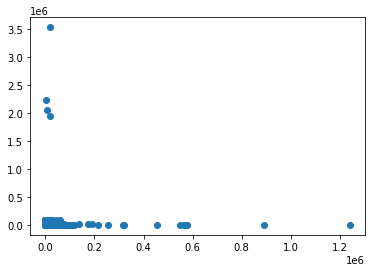

In [23]:
plt.scatter(train_data_cpy['distance'],train_data_cpy['trip_duration'])


In [24]:
train_data_cpy['pickup_datetime'] = pd.to_datetime(train_data_cpy['pickup_datetime'])
train_data_cpy['dropoff_datetime'] = pd.to_datetime(train_data_cpy['dropoff_datetime'])

In [25]:
def datetime_to_float(d):
    return d.timestamp()
temp = train_data_cpy['pickup_datetime'].apply(datetime_to_float)

In [26]:
def datetime_to_float(d):
    return d.timestamp()

def normalize_numeric_data(data):
    y = data['trip_duration']
    y_train = np.asarray(y).astype('float32')
    data = data.drop(['trip_duration'], axis=1)
    date_time = data.select_dtypes(include=['datetime64'])
    for column in date_time:
        date_time[column] = date_time[column].apply(datetime_to_float)
    numeric_data = data.select_dtypes(include=[np.number])
    from sklearn import preprocessing
    x = numeric_data.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df = pd.DataFrame(x_scaled)
    df_col = pd.concat([date_time,df], axis=1)
    #np_reader = tf.contrib.timeseries.NumpyReader(data={tf.contrib.timeseries.TrainEvalFeatures.TIMES: data['timestamp'].values, tf.contrib.timeseries.TrainEvalFeatures.VALUES : data['value'].values})
    X = df_col.to_numpy()
    #X = np.asarray(X).astype(np.float32)
    return X, y_train

In [27]:
X, y = normalize_numeric_data(train_data)

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

In [29]:
from keras import models
from keras import layers

def build_model():
    model = models.Sequential() 
    model.add(layers.Dense(64, activation='selu', input_shape=(X_train.shape[1],))) 
    model.add(layers.Dense(64, kernel_initializer='normal', activation='selu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mean_squared_logarithmic_error', metrics=['mean_squared_logarithmic_error', 'mae']) 
    return model

In [30]:
model = build_model()
history = model.fit(X_train, y_train, validation_split = 0.3, epochs=10, batch_size=1, shuffle=True, verbose=1)


Epoch 1/20
684103/684103 [==============================] - 825s 1ms/step - loss: 0.3138 - mean_squared_logarithmic_error: 0.3138 - mae: 402.5243 - val_loss: 0.2692 - val_mean_squared_logarithmic_error: 0.2692 - val_mae: 392.5753
Epoch 2/20
684103/684103 [==============================] - 866s 1ms/step - loss: 0.2747 - mean_squared_logarithmic_error: 0.2747 - mae: 386.8651 - val_loss: 0.2751 - val_mean_squared_logarithmic_error: 0.2751 - val_mae: 393.2105
Epoch 3/20
684103/684103 [==============================] - 877s 1ms/step - loss: 0.2716 - mean_squared_logarithmic_error: 0.2716 - mae: 385.4752 - val_loss: 0.2719 - val_mean_squared_logarithmic_error: 0.2719 - val_mae: 392.6176
Epoch 4/20
513588/684103 [=====================>........] - ETA: 2:44 - loss: 0.2686 - mean_squared_logarithmic_error: 0.2686 - mae: 382.4003Buffered data was truncated after reaching the output size limit.

In [31]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_squared_logarithmic_error,mae,val_loss,val_mean_squared_logarithmic_error,val_mae,epoch
15,0.266086,0.266086,383.631134,0.259809,0.259809,387.251251,15
16,0.266870,0.266870,383.644653,0.258257,0.258257,387.009705,16
17,0.267587,0.267587,383.541473,0.264810,0.264810,390.289581,17
18,0.268107,0.268107,383.656525,0.268819,0.268819,391.124481,18
19,0.269329,0.269329,383.764984,0.253158,0.253158,386.459412,19


In [ ]:
! pip install git+https://github.com/tensorflow/docs

Text(0, 0.5, 'mean_squared_logarithmic_error [ETA]')

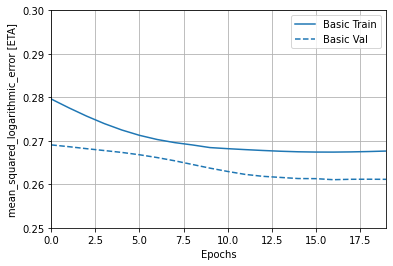

In [45]:
import tensorflow as tf
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)

plotter.plot({'Basic': history}, metric = "mean_squared_logarithmic_error")
plt.ylim([0.25, 0.3])
plt.ylabel('mean_squared_logarithmic_error [ETA]')

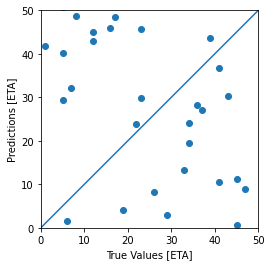

In [46]:
test_predictions = model.predict(X_test).flatten()
a = plt.axes(aspect='equal')
plt.scatter(y_test, test_predictions)
plt.xlabel('True Values [ETA]')
plt.ylabel('Predictions [ETA]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


In [35]:
test_predictions

array([1216.2965, 1300.1786,  582.1137, ...,  313.5571,  687.8677,
        227.7812], dtype=float32)

In [36]:
y_test

array([692., 990., 647., ..., 258., 243., 475.], dtype=float32)

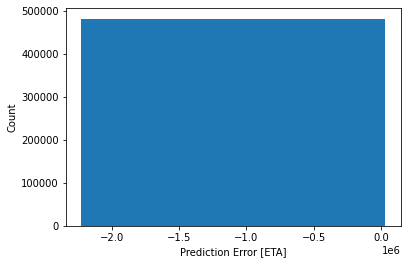

In [51]:
error = test_predictions - y_test
plt.hist(error, bins = 1)
plt.xlabel("Prediction Error [ETA]")
_ = plt.ylabel("Count")

In [48]:
error

array([ 524.2965 ,  310.1786 ,  -64.88629, ...,   55.5571 ,  444.86768,
       -247.2188 ], dtype=float32)